## Hcondever variable and frailty index

#### Gavin Qu, May 30th

#### We need to create wave-specific hcondever variables. This involves iterating through each wave and updating the hcondever variable for each wave.

In [27]:
import pandas as pd
import numpy as np
import os

# Base directory containing the data files
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'

# List of base variable names to extract, including 'pidp'
base_hcond_variables = [
    'pidp', 'hcond1', 'hcond2', 'hcond3', 'hcond4', 'hcond5', 'hcond6', 'hcond7',
    'hcond8', 'hcond9', 'hcond10', 'hcond11', 'hcond12', 'hcond13', 'hcond14',
    'hcond15', 'hcond16', 'hcond17',
    'hcondn1', 'hcondn2', 'hcondn3', 'hcondn4', 'hcondn5', 'hcondn6', 'hcondn7',
    'hcondn8', 'hcondn9', 'hcondn10', 'hcondn11', 'hcondn12', 'hcondn13', 'hcondn14',
    'hcondn15', 'hcondn16', 'hcondn17', 'hcondnew1', 'hcondnew2',
    'hcondnew3', 'hcondnew4', 'hcondnew5', 'hcondnew6', 'hcondnew7', 'hcondnew8',
    'hcondnew10', 'hcondnew11', 'hcondnew12', 'hcondnew13', 'hcondnew14', 'hcondnew15',
    'hcondnew16'
]

base_disdif_variables = [f'disdif{i}' for i in range(1, 12)]

# Combine all variable names to extract
base_variables = ['pidp'] + base_hcond_variables[1:] + base_disdif_variables

# Wave prefixes from 'a' to 'm'
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Function to load and filter wave data
def load_wave_data(wave_prefix, base_dir, base_variables):
    file_path = os.path.join(base_dir, f'{wave_prefix}_indresp.dta')
    if os.path.exists(file_path):
        print(f"Loading data from {file_path}")
        wave_data = pd.read_stata(file_path, convert_categoricals=False)
        
        # Construct the actual variable names for the current wave
        wave_variables = [f'{wave_prefix}_{var}' if var != 'pidp' else var for var in base_variables]
        age_column = f'{wave_prefix}_age_dv'
        wave_variables.append(age_column)
        
        # Find the intersection of desired variables and available columns
        available_columns = set(wave_variables).intersection(wave_data.columns)
        print(f"Available columns in {wave_prefix}: {available_columns}")
        
        # Select only the available columns
        if available_columns:
            selected_data = wave_data[list(available_columns)].copy()
            selected_data['wave'] = wave_prefix
            return selected_data
    return None

# List to store data from each wave
all_waves_data = []

# Loop through wave prefixes
for prefix in wave_prefixes:
    wave_data = load_wave_data(prefix, base_dir, base_variables)
    if wave_data is not None:
        all_waves_data.append(wave_data)

# Combine all waves into a single DataFrame
if all_waves_data:
    combined_data = pd.concat(all_waves_data, ignore_index=True)

    # Load the death information from xhhrel.dta
    death_file_path = os.path.join(base_dir, 'xhhrel.dta')
    death_data = pd.read_stata(death_file_path, convert_categoricals=False)

    # Select the pidp and death column
    death_data = death_data[['pidp', 'dcsedfl_dv']]

    # Merge the death information with the combined data
    combined_data = combined_data.merge(death_data, on='pidp', how='left')

    # List of columns to clean (excluding 'pidp', 'wave', 'dcsedfl_dv', and age columns)
    age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]
    columns_to_clean = [col for col in combined_data.columns if col not in ['pidp', 'wave', 'dcsedfl_dv'] + age_columns]

    # Clean the data: treat everything that's not a 1 or negative as 0
    def clean_data(df, columns):
        df_cleaned = df.copy()
        for col in columns:
            df_cleaned[col] = df_cleaned[col].apply(lambda x: 1 if x == 1 else (0 if x >= 0 else x))
        return df_cleaned

    # Apply the cleaning function
    cleaned_combined_data = clean_data(combined_data, columns_to_clean)

    # Create wave-specific hcondever variables
    for prefix in wave_prefixes:
        for i in range(1, 18):
            ever_var = f'{prefix}_hcondever{i}'
            cond_cols = [col for col in [f'{prefix}_hcond{i}', f'{prefix}_hcondn{i}', f'{prefix}_hcondnew{i}'] if col in cleaned_combined_data.columns]
            cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1) if cond_cols else np.nan

    # Propagate hcondever values across waves
    for i in range(1, 18):
        for j in range(1, len(wave_prefixes)):
            prev_prefix = wave_prefixes[j-1]
            curr_prefix = wave_prefixes[j]
            prev_var = f'{prev_prefix}_hcondever{i}'
            curr_var = f'{curr_prefix}_hcondever{i}'
            cond_cols = [prev_var, f'{curr_prefix}_hcond{i}', f'{curr_prefix}_hcondn{i}', f'{curr_prefix}_hcondnew{i}']
            cond_cols = [col for col in cond_cols if col in cleaned_combined_data.columns]
            if cond_cols:
                cleaned_combined_data[curr_var] = cleaned_combined_data[cond_cols].max(axis=1)
            else:
                cleaned_combined_data[curr_var] = np.nan

            # Set hcondever to 0 if all previous values are 0 or negative
            previous_values = cleaned_combined_data[[f'{wave_prefixes[k]}_hcondever{i}' for k in range(j)]].fillna(-1)
            cleaned_combined_data[curr_var] = cleaned_combined_data[curr_var].where(
                ~((previous_values <= 0).all(axis=1) & (cleaned_combined_data[curr_var] != 1)), 0)

            # Set hcondever to missing if both current and previous values are negative or missing
            current_and_previous = cleaned_combined_data[[prev_var, curr_var]]
            cleaned_combined_data[curr_var] = cleaned_combined_data[curr_var].where(
                ~((current_and_previous.isna().all(axis=1)) | ((current_and_previous < 0).all(axis=1))), np.nan)

    # Update age for subsequent waves
    for i, prefix in enumerate(wave_prefixes[1:], start=1):
        cleaned_combined_data[f'{prefix}_age_dv'] = cleaned_combined_data[f'a_age_dv'] + i

    # Display the first few rows of the cleaned combined data
    print("Cleaned Combined Data Head:")
    print(cleaned_combined_data.head())

    # Save the cleaned combined data to a new Stata file
    output_dir = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data'
    os.makedirs(output_dir, exist_ok=True)
    cleaned_combined_data_path = os.path.join(output_dir, 'cleaned_combined_ukhls_hcond_disdif_death_data.dta')
    cleaned_combined_data.to_stata(cleaned_combined_data_path, write_index=False)

    print(f"Cleaned combined data saved to {cleaned_combined_data_path}")
else:
    print("No data was loaded. Please check the file paths and variable names.")


Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/a_indresp.dta
Available columns in a: {'a_disdif11', 'a_hcond4', 'pidp', 'a_hcond5', 'a_hcond9', 'a_disdif8', 'a_disdif2', 'a_hcond2', 'a_hcond16', 'a_hcond6', 'a_hcond13', 'a_disdif9', 'a_disdif3', 'a_hcond17', 'a_disdif6', 'a_hcond11', 'a_hcond3', 'a_disdif5', 'a_disdif1', 'a_hcond12', 'a_hcond14', 'a_hcond1', 'a_disdif10', 'a_disdif7', 'a_age_dv', 'a_hcond10', 'a_hcond15', 'a_hcond7', 'a_hcond8', 'a_disdif4'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/b_indresp.dta
Available columns in b: {'b_disdif5', 'pidp', 'b_hcondn10', 'b_hcondn2', 'b_disdif4', 'b_disdif8', 'b_hcondn12', 'b_hcondn14', 'b_hcondn13', 'b_disdif11', 'b_hcondn9', 'b_hcondn16', 'b_hcondn1', 'b_age_dv', 'b_disdif1', 'b_hcondn8', 'b_hcondn11', 'b_hcondn15', 'b_disdif2', 'b_hcondn17', 'b_hcondn5', 'b_disdif6', 'b_hcondn6', 'b_disdif10', 'b_disdif7', 'b_disdif9', 'b_

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2765753120.py:34: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_data = pd.read_stata(file_path, convert_categoricals=False)


Available columns in c: {'c_hcondn11', 'c_hcond2', 'pidp', 'c_hcond10', 'c_hcondn3', 'c_disdif11', 'c_hcondn4', 'c_hcondn9', 'c_hcondn17', 'c_hcondn13', 'c_hcond8', 'c_hcond11', 'c_disdif10', 'c_disdif9', 'c_disdif6', 'c_disdif3', 'c_hcond6', 'c_hcondn14', 'c_disdif1', 'c_hcond7', 'c_hcond17', 'c_disdif2', 'c_hcond12', 'c_hcondn12', 'c_hcondn6', 'c_hcondn1', 'c_hcondn15', 'c_hcond16', 'c_hcondn8', 'c_hcond9', 'c_age_dv', 'c_disdif7', 'c_hcond4', 'c_hcond14', 'c_hcond13', 'c_disdif8', 'c_hcondn5', 'c_disdif5', 'c_hcond5', 'c_hcondn16', 'c_hcondn10', 'c_disdif4', 'c_hcond15', 'c_hcond3', 'c_hcondn2', 'c_hcond1', 'c_hcondn7'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/d_indresp.dta
Available columns in d: {'d_hcond4', 'pidp', 'd_hcondn2', 'd_hcondn17', 'd_disdif2', 'd_hcond2', 'd_disdif5', 'd_disdif11', 'd_hcond9', 'd_hcond16', 'd_disdif4', 'd_hcondn9', 'd_hcondn10', 'd_age_dv', 'd_hcondn7', 'd_hcondn16', 'd_hcondn5', 'd_hcondn15', 

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2765753120.py:34: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  wave_data = pd.read_stata(file_path, convert_categoricals=False)


Available columns in e: {'e_disdif2', 'pidp', 'e_hcondn5', 'e_hcond12', 'e_hcond2', 'e_hcondn12', 'e_hcond15', 'e_hcondn14', 'e_disdif7', 'e_disdif6', 'e_hcondn9', 'e_disdif11', 'e_hcond4', 'e_hcond13', 'e_hcondn1', 'e_hcondn7', 'e_disdif1', 'e_hcond1', 'e_disdif5', 'e_hcondn17', 'e_hcondn6', 'e_hcond5', 'e_disdif10', 'e_hcond17', 'e_hcondn13', 'e_hcondn8', 'e_hcond9', 'e_hcond16', 'e_hcond7', 'e_disdif8', 'e_hcond3', 'e_hcondn3', 'e_hcondn15', 'e_hcondn16', 'e_disdif9', 'e_age_dv', 'e_hcond11', 'e_hcondn10', 'e_hcond8', 'e_hcondn2', 'e_hcond10', 'e_disdif4', 'e_disdif3', 'e_hcondn4', 'e_hcondn11', 'e_hcond14', 'e_hcond6'}
Loading data from /Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls/f_indresp.dta
Available columns in f: {'f_disdif2', 'f_hcond6', 'pidp', 'f_hcondn1', 'f_hcondn9', 'f_hcondn4', 'f_hcond11', 'f_hcond16', 'f_disdif8', 'f_disdif6', 'f_hcond9', 'f_hcondn17', 'f_disdif3', 'f_disdif9', 'f_hcond1', 'f_disdif5', 'f_hcond2', 'f_hcond3', 'f_di

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2765753120.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1) if cond_cols else np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2765753120.py:94: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cleaned_combined_data[ever_var] = cleaned_combined_data[cond_cols].max(axis=1) if cond_cols else np.nan
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/276

Cleaned Combined Data Head:
   a_disdif11  a_hcond4      pidp  a_hcond5  a_hcond9  a_disdif8  a_disdif2  \
0        -8.0       0.0  68001367       0.0       0.0       -8.0       -8.0   
1        -8.0       0.0  68004087       0.0       0.0       -8.0       -8.0   
2         0.0       0.0  68006127       0.0       0.0        0.0        0.0   
3        -8.0       0.0  68006135       0.0       0.0       -8.0       -8.0   
4         0.0       0.0  68006807       0.0       0.0        0.0        1.0   

   a_hcond2  a_hcond16  a_hcond6  ...  m_hcondever8  m_hcondever9  \
0       0.0        0.0       0.0  ...           0.0           0.0   
1       0.0        0.0       0.0  ...           0.0           0.0   
2       0.0        0.0       0.0  ...           0.0           0.0   
3       0.0        0.0       0.0  ...           0.0           0.0   
4       1.0        1.0       0.0  ...           0.0           0.0   

   m_hcondever10  m_hcondever11  m_hcondever12  m_hcondever13  m_hcondever14  \
0 

### Check the count of disdif and hcondever when == 1

In [21]:
import pandas as pd

# Load the cleaned combined data
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize dictionary to store counts
counts_tally = {
    'Wave': [],
    'Disdif 1 Count': [],
    'Hcondever 1 Count': [],
    'Hcondever Missing Count': [],
    'Hcondever 0 Count': []
}

# Calculate counts for each wave
for prefix in wave_prefixes:
    disdif_cols = [f'{prefix}_disdif{i}' for i in range(1, 12)]
    hcondever_cols = [f'{prefix}_hcondever{i}' for i in range(1, 18)]
    
    if any(col in cleaned_combined_data.columns for col in disdif_cols):
        counts_tally['Wave'].append(prefix)
        
        # Filter out rows with negative values in disdif columns
        valid_data = cleaned_combined_data[(cleaned_combined_data[disdif_cols] >= 0).all(axis=1)]
        
        # Count values of 1 in disdif columns
        disdif_1_count = (valid_data[disdif_cols] == 1).sum().sum()
        
        # Count individuals with at least one hcondever == 1 in any column
        hcondever_1_count = (valid_data[hcondever_cols] == 1).any(axis=1).sum()
        
        # Count individuals with all hcondever == 0 in all columns
        hcondever_0_count = ((valid_data[hcondever_cols] == 0).all(axis=1) & (valid_data[hcondever_cols] >= 0).all(axis=1)).sum()
        
        # Count missing values in hcondever columns
        hcondever_missing_count = (valid_data[hcondever_cols].isna().all(axis=1)).sum()
        
        counts_tally['Disdif 1 Count'].append(disdif_1_count)
        counts_tally['Hcondever 1 Count'].append(hcondever_1_count)
        counts_tally['Hcondever 0 Count'].append(hcondever_0_count)
        counts_tally['Hcondever Missing Count'].append(hcondever_missing_count)

# Convert dictionary to DataFrame
counts_tally_df = pd.DataFrame(counts_tally)

# Display the tally
print(counts_tally_df)


   Wave  Disdif 1 Count  Hcondever 1 Count  Hcondever Missing Count  \
0     a           28628              13238                        0   
1     b           27918               4234                        0   
2     c           24290               3855                        0   
3     d           23645               3086                        0   
4     e           22194               2712                        0   
5     f           20405               3149                        0   
6     g           20644               2309                        0   
7     h           22039               3906                        0   
8     i           20519               4323                        0   
9     j           20046                259                        0   
10    k           18679               3796                        0   
11    l           15601               3214                        0   
12    m           14792               3623                        0   

    H

### Frailty index with death counted as 1 using the hcondever and disdiff variables, exclude negative values

In [22]:
import pandas as pd
import os

# Define file paths
base_dir = '/Users/gavinqu/Desktop/School/Dissertation/UKDA-6614-stata/stata/stata13_se/ukhls'
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'

# Load the cleaned combined data
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Load the death information from xhhrel.dta
death_file_path = os.path.join(base_dir, 'xhhrel.dta')
death_data = pd.read_stata(death_file_path, convert_categoricals=False)

# Extract the pidp and dcsedw_dv (death wave)
death_data = death_data[['pidp', 'dcsedw_dv']]

# Map death wave values to corresponding wave prefixes
death_wave_map = {
    20: 'b', 21: 'c', 22: 'd', 23: 'e', 24: 'f', 25: 'g',
    26: 'h', 27: 'i', 28: 'j', 29: 'k', 30: 'l', 31: 'm'
}

# Function to filter individuals aged 20 and above
def filter_age_range(df, age_start, wave_prefixes):
    age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]
    filtered_dfs = []
    for i, age_column in enumerate(age_columns):
        if age_column in df.columns:
            age_data = df[['pidp', age_column]].copy()
            age_data.rename(columns={age_column: 'age'}, inplace=True)
            age_data['wave'] = wave_prefixes[i]
            age_data['age'] += i  # Add years for subsequent waves
            filtered_dfs.append(age_data[age_data['age'] >= age_start])
    return pd.concat(filtered_dfs, ignore_index=True)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Filter individuals aged 20 and above
filtered_data = filter_age_range(cleaned_combined_data, 20, wave_prefixes)

# Merge filtered data with the original cleaned data to get other variables
merged_data = pd.merge(filtered_data, cleaned_combined_data, on=['pidp', 'wave'])

# Function to create cumulative hcondever variables
def create_cumulative_hcondever(df, wave_prefixes):
    for i in range(1, 18):
        ever_var = f'hcondever{i}'
        cumulative_series = pd.Series([0] * len(df))
        for prefix in wave_prefixes:
            wave_var = f'{prefix}_hcond{i}'
            if wave_var in df.columns:
                cumulative_series = cumulative_series.combine_first(df[wave_var].where(df[wave_var] == 1, 0))
        df[ever_var] = cumulative_series
    return df

# Create cumulative hcondever variables
merged_data = create_cumulative_hcondever(merged_data, wave_prefixes)

# Function to calculate the frailty index for each wave
def calculate_frailty_index(df, wave_prefixes):
    for prefix in wave_prefixes:
        hcondever_cols = [f'hcondever{i}' for i in range(1, 18)]
        disdif_cols = [f'{prefix}_disdif{i}' for i in range(1, 12)]

        relevant_columns = hcondever_cols + disdif_cols
        frailty_col = f'{prefix}_frailty'

        # Treat negative values as missing
        df[relevant_columns] = df[relevant_columns].where(df[relevant_columns] >= 0, pd.NA)

        # Compute the sum and count of non-missing values
        non_missing_sum = df[relevant_columns].sum(axis=1, min_count=1)
        non_missing_count = df[relevant_columns].notna().sum(axis=1)

        # Condition 1: If all relevant columns are zero, set frailty to 0
        all_zero_condition = df[relevant_columns].fillna(0).sum(axis=1) == 0

        # Condition 2: If all relevant columns are missing, set frailty to NaN
        all_missing_condition = non_missing_count == 0

        # Calculate frailty index
        df[frailty_col] = non_missing_sum / non_missing_count
        df.loc[all_zero_condition, frailty_col] = 0
        df.loc[all_missing_condition, frailty_col] = pd.NA

        df[frailty_col] = df[frailty_col].round(5)
    return df

# Calculate the frailty index for each wave
frailty_data = calculate_frailty_index(merged_data, wave_prefixes)

# Update the frailty index for deceased individuals
for wave_value, wave_prefix in death_wave_map.items():
    death_pids = death_data[death_data['dcsedw_dv'] == wave_value]['pidp']
    frailty_data.loc[frailty_data['pidp'].isin(death_pids), f'{wave_prefix}_frailty'] = 1

# Ensure all columns are of valid types for Stata export
frailty_data = frailty_data.apply(pd.to_numeric, errors='ignore')

# Display the first few rows of the frailty data
print("Frailty Data Head:")
print(frailty_data[[col for col in frailty_data.columns if 'frailty' in col]].head())

# Save the frailty index data to a Stata file
frailty_data.to_stata(frailty_index_path, write_index=False)

print(f"Frailty index data saved to {frailty_index_path}")


/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2801460287.py:55: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cumulative_series = cumulative_series.combine_first(df[wave_var].where(df[wave_var] == 1, 0))
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2801460287.py:55: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  cumulative_series = cumulative_series.combine_first(df[wave_var].where(df[wave_var] == 1, 0))
/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2801460287.py:55: FutureWarning: The behavior of 

Frailty Data Head:
   a_frailty  b_frailty  c_frailty  d_frailty  e_frailty  f_frailty  \
0    0.00000        0.0        0.0        0.0        0.0        0.0   
1    0.00000        0.0        0.0        0.0        0.0        0.0   
2    0.03571        0.0        0.0        0.0        0.0        0.0   
3    0.10714        0.0        0.0        0.0        0.0        0.0   
4    0.00000        0.0        0.0        0.0        0.0        0.0   

   g_frailty  h_frailty  i_frailty  j_frailty  k_frailty  l_frailty  m_frailty  
0        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        1.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
Frailty index data saved to /Users/gavinqu/Desktop/School/Dissertati

### Non-zero count of frailty for each wave

In [18]:
import pandas as pd

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize a dictionary to store counts
frailty_counts = {
    'Wave': [],
    'Non-zero Frailty Count': [],
    'Zero Frailty Count': [],
    'Missing Frailty Count': []
}

# Calculate the counts for each wave
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    if frailty_col in frailty_data.columns:
        non_zero_count = (frailty_data[frailty_col] > 0).sum()
        zero_count = (frailty_data[frailty_col] == 0).sum()
        missing_count = frailty_data[frailty_col].isna().sum()
        
        frailty_counts['Wave'].append(prefix)
        frailty_counts['Non-zero Frailty Count'].append(non_zero_count)
        frailty_counts['Zero Frailty Count'].append(zero_count)
        frailty_counts['Missing Frailty Count'].append(missing_count)

# Convert the dictionary to a DataFrame
frailty_counts_df = pd.DataFrame(frailty_counts)

# Display the counts
print("Frailty Index Counts:")
print(frailty_counts_df)

# Save the counts to a CSV file
output_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_counts.csv'
frailty_counts_df.to_csv(output_path, index=False)
print(f"Frailty counts saved to {output_path}")


Frailty Index Counts:
   Wave  Non-zero Frailty Count  Zero Frailty Count  Missing Frailty Count
0     a                   10633              322108                      0
1     b                    8014              324727                      0
2     c                    7361              325380                      0
3     d                    7075              325666                      0
4     e                    6667              326074                      0
5     f                    6316              326425                      0
6     g                    6425              326316                      0
7     h                    7507              325234                      0
8     i                    6985              325756                      0
9     j                    7050              325691                      0
10    k                    6766              325975                      0
11    l                    6219              326522                      0
12 

### Smoothed Line Plot of Frailty against Age 

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/1013468238.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')


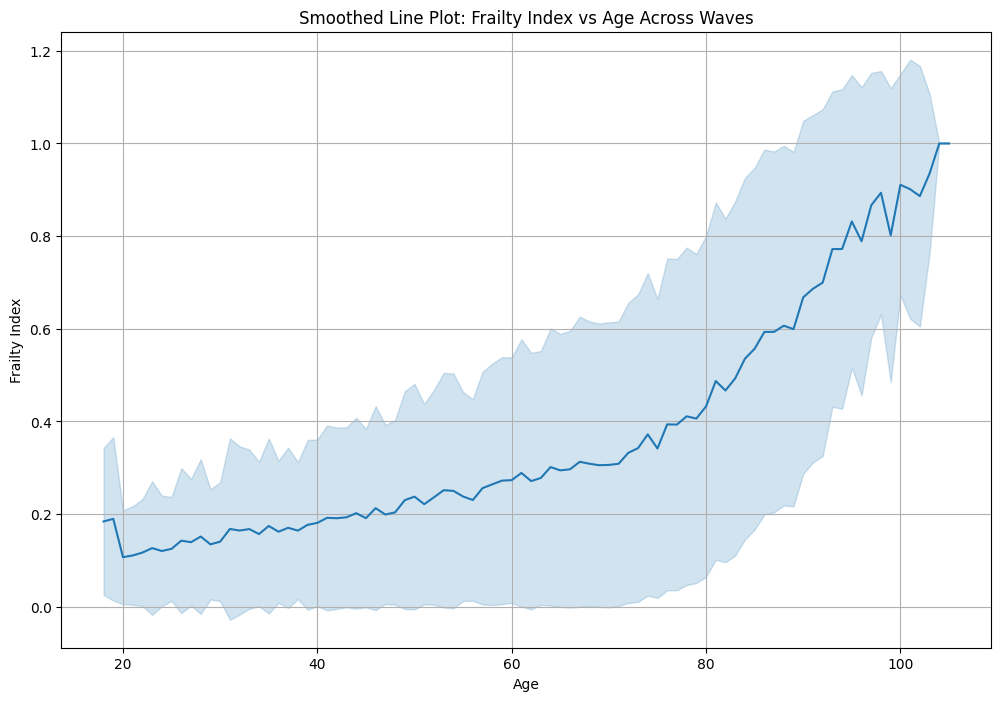

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] > 0]  # Filter out zero frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves')
plt.grid(True)
plt.show()


### Smooth line plot but including frailty == 0

/var/folders/n2/8hz3y3r90rj63gkzgrl1hwg40000gn/T/ipykernel_50045/2038237390.py:34: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')


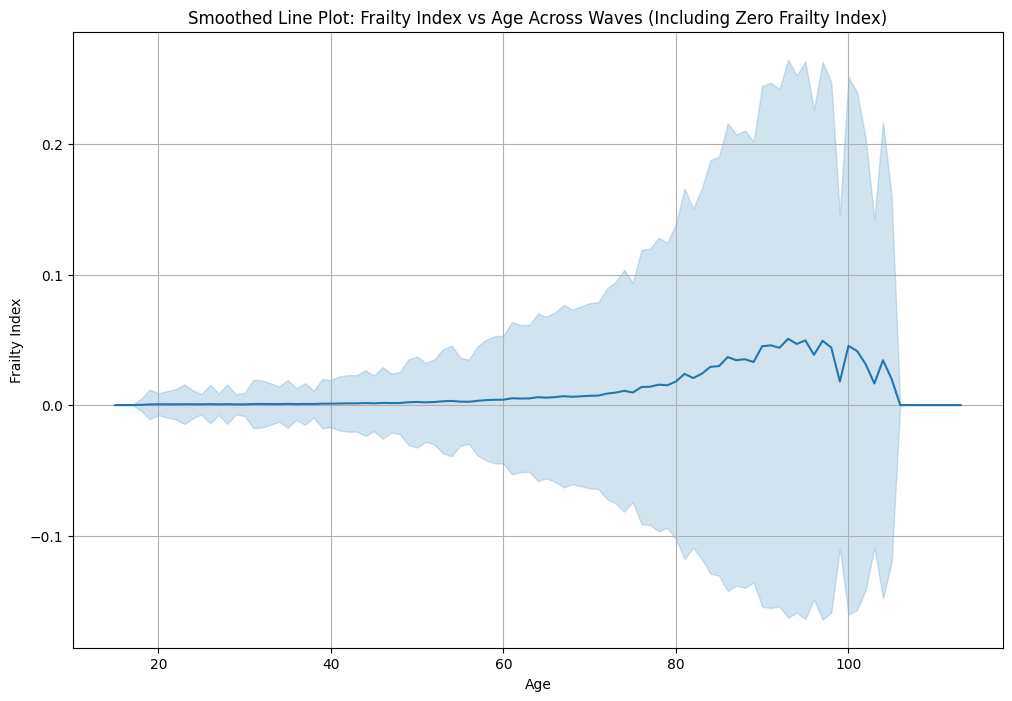

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Load the cleaned combined data to get the age variables
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes and age column prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]
age_columns = [f'{prefix}_age_dv' for prefix in wave_prefixes]

# Prepare data for the smoothed line plot
scatter_data = pd.DataFrame()

for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    age_col = f'{prefix}_age_dv'
    if frailty_col in frailty_data.columns and age_col in combined_data.columns:
        temp_df = frailty_data[['pidp', frailty_col]].copy()
        temp_age_df = combined_data[['pidp', age_col]].copy()
        temp_df = temp_df.merge(temp_age_df, on='pidp')
        temp_df = temp_df[temp_df[frailty_col] >= 0]  # Filter out negative frailty index values
        temp_df['wave'] = prefix
        temp_df = temp_df.rename(columns={frailty_col: 'frailty_index', age_col: 'age'})
        scatter_data = pd.concat([scatter_data, temp_df], ignore_index=True)

# Create smoothed line plot
plt.figure(figsize=(12, 8))
sns.lineplot(x='age', y='frailty_index', data=scatter_data, ci='sd')
plt.xlabel('Age')
plt.ylabel('Frailty Index')
plt.title('Smoothed Line Plot: Frailty Index vs Age Across Waves (Including Zero Frailty Index)')
plt.grid(True)
plt.show()


### Test for the decline in non-zero frailty values and positive values in disdif

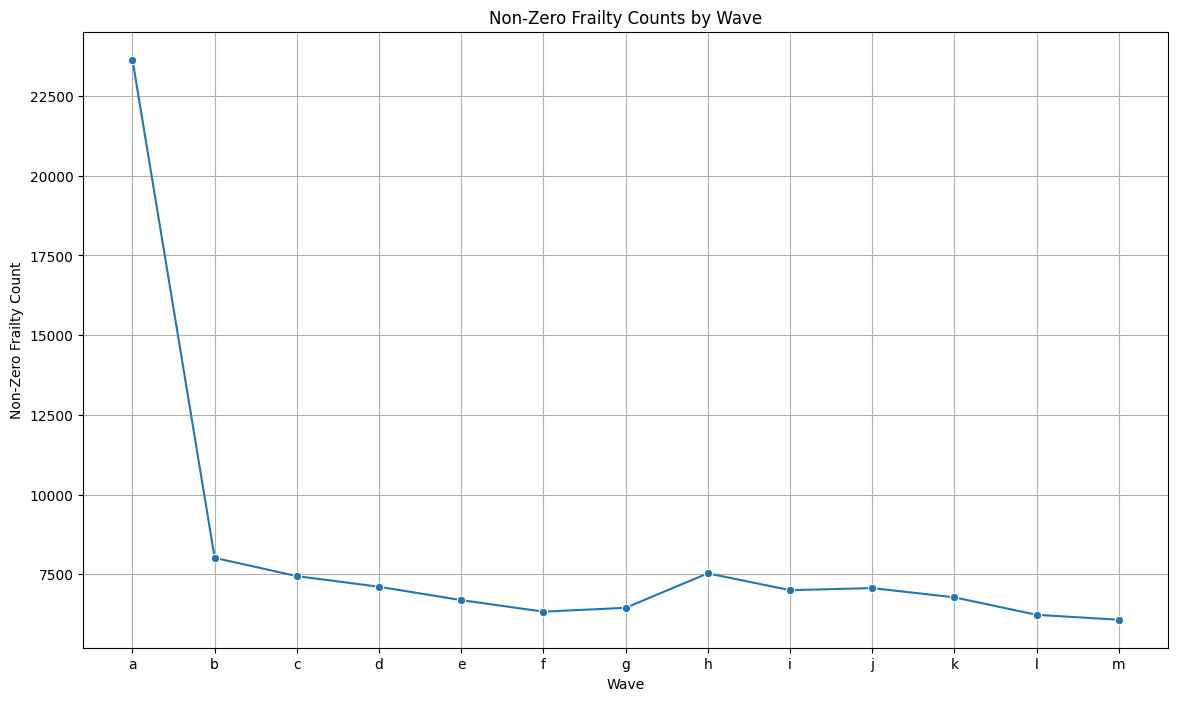

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the frailty index data
frailty_index_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/frailty_index_with_death.dta'
frailty_data = pd.read_stata(frailty_index_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize dictionary to store counts
frailty_counts = {
    'Wave': [],
    'Non-Zero Frailty Count': []
}

# Calculate the non-zero frailty counts for each wave
for prefix in wave_prefixes:
    frailty_col = f'{prefix}_frailty'
    
    if frailty_col in frailty_data.columns:
        non_zero_frailty_count = (frailty_data[frailty_col] > 0).sum()
        
        frailty_counts['Wave'].append(prefix)
        frailty_counts['Non-Zero Frailty Count'].append(non_zero_frailty_count)

# Convert dictionary to DataFrame
frailty_counts_df = pd.DataFrame(frailty_counts)

# Plot the non-zero frailty counts by wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=frailty_counts_df, x='Wave', y='Non-Zero Frailty Count', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Frailty Count')
plt.title('Non-Zero Frailty Counts by Wave')
plt.grid(True)
plt.show()


### Plot of disdif by non-unique pidp

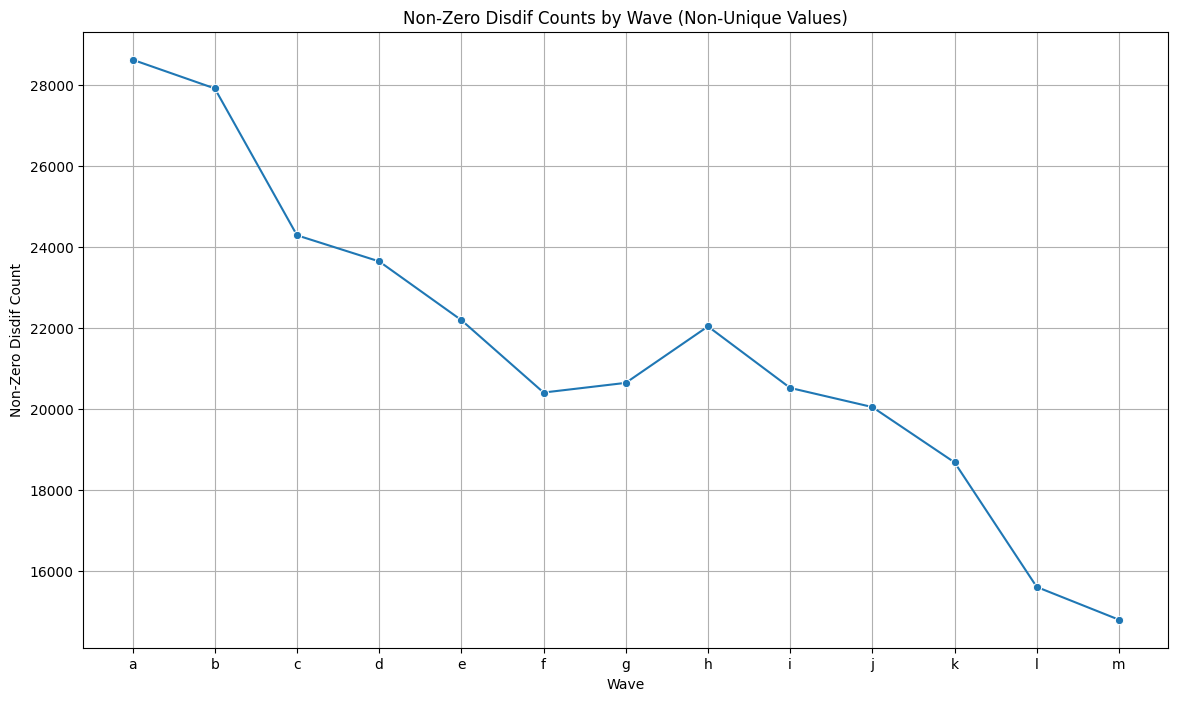

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned combined data
cleaned_combined_data_path = '/Users/gavinqu/Desktop/School/Dissertation/EssexDissertation/Data/cleaned_combined_ukhls_hcond_disdif_death_data.dta'
cleaned_combined_data = pd.read_stata(cleaned_combined_data_path)

# Define wave prefixes
wave_prefixes = [chr(i) for i in range(ord('a'), ord('n'))]

# Initialize dictionary to store non-zero counts
non_zero_disdif_counts = {
    'Wave': [],
    'Non-Zero Disdif': []
}

# Calculate non-zero counts for each wave
for prefix in wave_prefixes:
    disdif_cols = [f'{prefix}_disdif{i}' for i in range(1, 12)]
    
    if any(col in cleaned_combined_data.columns for col in disdif_cols):
        non_zero_disdif_counts['Wave'].append(prefix)
        
        # Count non-zero, non-negative values
        non_zero_disdif = ((cleaned_combined_data[disdif_cols] > 0) & (cleaned_combined_data[disdif_cols] >= 0)).sum().sum()
        
        non_zero_disdif_counts['Non-Zero Disdif'].append(non_zero_disdif)

# Convert dictionary to DataFrame
non_zero_disdif_counts_df = pd.DataFrame(non_zero_disdif_counts)

# Plot the non-zero counts for disdif by wave
plt.figure(figsize=(14, 8))
sns.lineplot(data=non_zero_disdif_counts_df, x='Wave', y='Non-Zero Disdif', marker='o')
plt.xlabel('Wave')
plt.ylabel('Non-Zero Disdif Count')
plt.title('Non-Zero Disdif Counts by Wave (Non-Unique Values)')
plt.grid(True)
plt.show()
